## 0. Downloading dataset

In [9]:
dataset_path = '../../dataset/'
%env dataset_path = {dataset_path}
!mkdir -p $dataset_path

env: dataset_path=../../dataset/


In [16]:
!wget https://storage.googleapis.com/samanantar-public/V0.2/data/en2indic/en-hi.zip -P $dataset_path
!unzip $dataset_path/en-hi.zip -d $dataset_path

Archive:  ../../dataset//en-hi.zip
   creating: ../../dataset/en-hi/
 extracting: ../../dataset/en-hi/train.hi  
 extracting: ../../dataset/en-hi/train.en  


## 1. Installing dependencies

In [12]:
%%capture
!pip install seaborn
!pip install wordcloud
!pip install inltk
!pip install indic-nlp-library

In [13]:
# one time setup for inltk
from inltk.inltk import setup
setup('hi')

RuntimeError: This event loop is already running

We'll only do this for the first time.
We'll only do this for the first time.
Done!


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split

pd.set_option("display.precision", 10)

In [17]:
# declaring variables with paths to the dataset

dataset_root = dataset_path + "en-hi/"
english_set = dataset_root + "train.en"
hindi_set = dataset_root + "train.hi"

# 2. Overview of the English dataset

In [18]:
with open(english_set) as f:
    X = f.readlines()

print("Total Number of English Sentences are : ", len(X))

print("\nHere are some Sample English Sentences\n")

for i, sentence in enumerate(X[1:5]):
    print("Sentence Number ", i+1, " : ", sentence)

Total Number of English Sentences are :  8466307

Here are some Sample English Sentences

Sentence Number  1  :  The European Union has seven principal decision-making bodies, its institutions: the European Parliament, the European Council, the Council of the European Union, the European Commission, the Court of Justice of the European Union, the European Central Bank and the European Court of Auditors.

Sentence Number  2  :  The Congress leader represents Sivaganga Lok Sabha segment from Tamil Nadu.

Sentence Number  3  :  Prompt the user about connection attempts

Sentence Number  4  :  Further, the Minister announced that Deposit Insurance and Credit Guarantee Corporation (DICGC) has been permitted to increase Deposit Insurance coverage to Rs.



# 3. Overview of the Hindi dataset

In [19]:
with open(hindi_set) as f:
    Y = f.readlines()

print("Total Number of Hindi Sentences are : ", len(Y))
print("\nHere are the corresponding Hindi Translations\n")

for i, sentence in enumerate(Y[1:5]):
    print("Sentence Number ", i+1, " : ", sentence)

Total Number of Hindi Sentences are :  8466307

Here are the corresponding Hindi Translations

Sentence Number  1  :  यूरोपीय संघ के महत्वपूर्ण संस्थानों में यूरोपियन कमीशन, यूरोपीय संसद, यूरोपीय संघ परिषद, यूरोपीय न्यायलय एवं यूरोपियन सेंट्रल बैंक इत्यादि शामिल हैं।

Sentence Number  2  :  कांग्रेस नेता तमिलनाडु से शिवगंगा लोकसभा क्षेत्र का प्रतिनिधित्व करते हैं.

Sentence Number  3  :  संबंधन प्रयास के बारे में उपयोक्ता को प्रांप्ट करें

Sentence Number  4  :  वित्त मंत्री ने घोषणा कि जमा बीमा और ऋण गारंटी निगम (डीआईसीजीसी) को जमा राशि बीमा का दायरा, जो इस समय 1 लाख रुपये है उसे बढ़ाकर प्रति जमाकर्ता 5 लाख रुपये करने की अनुमति प्रदान कर दी गई है।



# 4. Preliminiary statistical analysis

### Extract sentence lengths

In [20]:
english_set_lengths = []
hindi_set_lengths = []

for eng_sentence in X:
    english_set_lengths.append(len(eng_sentence))

for hin_sentence in Y:
    hindi_set_lengths.append(len(hin_sentence))

print("The Maximum Length of a Single English sentence is %d, The Minimum length is %d and the Average is around %f" %(
    max(english_set_lengths), min(english_set_lengths), np.mean(english_set_lengths)))

print("The Maximum Length of a Single Hindi sentence is %d, The Minimum length is %d and the Average is around %f" %(
    max(hindi_set_lengths), min(hindi_set_lengths), np.mean(hindi_set_lengths)))

The Maximum Length of a Single English sentence is 86999, The Minimum length is 6 and the Average is around 96.731851
The Maximum Length of a Single Hindi sentence is 35322, The Minimum length is 6 and the Average is around 93.799217


### Distribution of lengths vs corresponding sentence counts

In [21]:
lengths = [100, 200, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
len_count = []

for j in range(len(lengths)):
    if j == 0:
        len_count.append(len([i for i in english_set_lengths if (i <= lengths[j])]))
    else:
        len_count.append(len([i for i in english_set_lengths if (i <= lengths[j] and i > lengths[j-1])]) + len_count[j-1])

percentage = list(np.array(len_count)/len(X))

distribution = pd.DataFrame(list(zip(lengths,len_count, percentage)), columns = ['Lengths', 'Count (<=)', 'Percentage of Dataset'])
distribution

,Lengths,Count (<=),Percentage of Dataset
0,100,5381956,0.6356910988
1,200,7755349,0.9160250154
2,400,8412646,0.9936618174
3,500,8443703,0.9973301228
4,750,8462155,0.9995095855
5,1000,8465243,0.9998743254
6,1500,8466123,0.9999782668
7,2000,8466206,0.9999880704
8,2500,8466233,0.9999912595
9,3000,8466240,0.9999920863


### Number of English sentences with length < 5000 

Number of sentences with length < 5000 :  8466266


<AxesSubplot:xlabel='Length', ylabel='Count'>

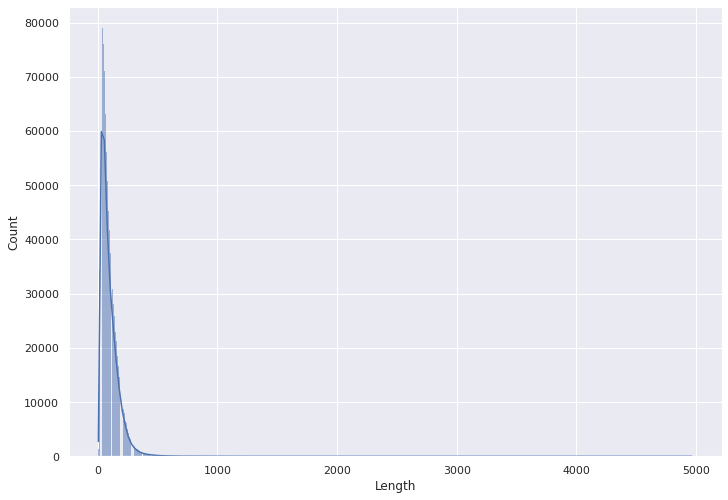

In [22]:
eng_u5000 = [i for i in english_set_lengths if i < 5000]
print("Number of sentences with length < 5000 : ", len(eng_u5000))

eng_df = pd.DataFrame(eng_u5000, columns =['Length'])

# histogram of lengths of English sentences with length < 5000
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = eng_df['Length'], kde = True)

### Number of English sentences with length < 1000

Number of sentences with length < 1000 :  8465238


<AxesSubplot:xlabel='Length', ylabel='Count'>

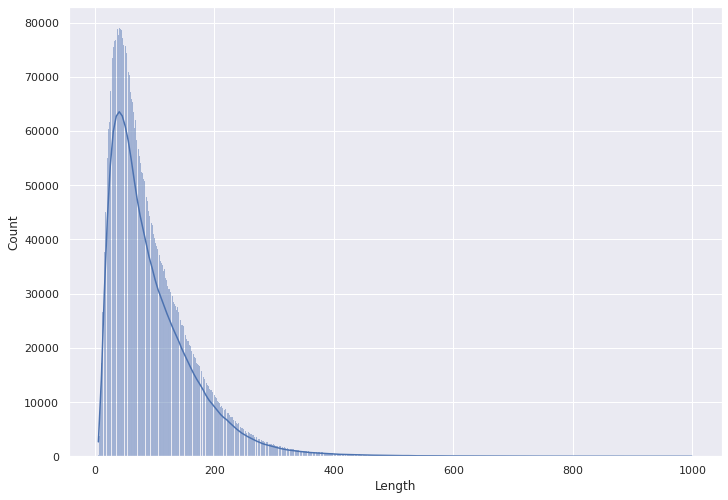

In [23]:
eng_u1000 = [i for i in english_set_lengths if i < 1000]
print("Number of sentences with length < 1000 : ", len(eng_u1000))

eng_df2 = pd.DataFrame(eng_u1000, columns =['Length'])

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = eng_df2['Length'], kde = True)

### Number of Hindi sentences with length < 2000

Number of Hindi sentences with length < 2000 :  8466212


<AxesSubplot:xlabel='Length', ylabel='Count'>

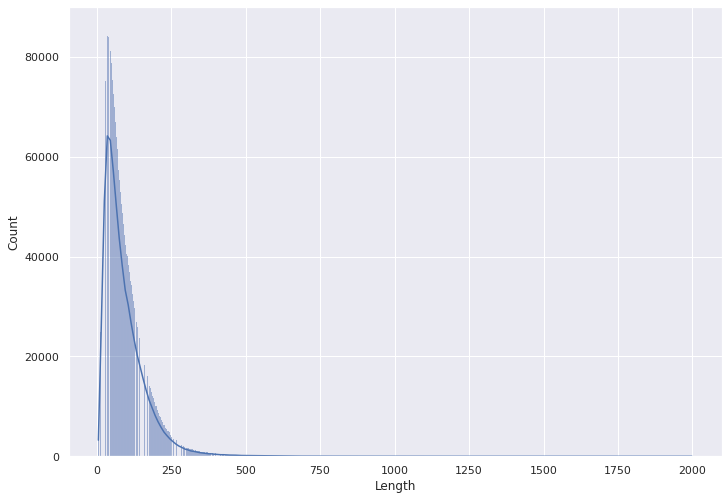

In [24]:
hin_u2000 = [i for i in hindi_set_lengths if i < 2000]
print("Number of Hindi sentences with length < 2000 : ", len(hin_u2000))

hin_df = pd.DataFrame(hin_u2000, columns =['Length'])

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = hin_df['Length'], kde = True)

# 5. Data Normalization

In [25]:
english_sentences = pd.DataFrame(X, columns = ['Text'])

In [26]:
english_sentences.head()

,Text
0,"In reply, Pakistan got off to a solid start.\n"
1,The European Union has seven principal decisio...
2,The Congress leader represents Sivaganga Lok S...
3,Prompt the user about connection attempts\n
4,"Further, the Minister announced that Deposit I..."


## English Normalization

In [27]:
!perl normalize-punctuation.perl -l en < $dataset_path/en-hi/train.en > $dataset_path/en-hi/train.normalized.en

In [29]:
english_set_normalized = dataset_root + '/train.normalized.en'

with open(english_set_normalized) as f:
    X_norm = f.readlines()

## Hindi Normalization

In [30]:
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

factory=IndicNormalizerFactory()
normalizer=factory.get_normalizer('hi')

In [31]:
# this step might take a few minutes to complete

Y_normalized = []
for index, input_text in enumerate(Y):
    output_text=normalizer.normalize(input_text)
    Y_normalized.append(output_text)

print("Sample Sentences : \n")
print(Y_normalized[1:5])

Sample Sentences : 

['यूरोपीय संघ के महत्वपूर्ण संस्थानों में यूरोपियन कमीशन, यूरोपीय संसद, यूरोपीय संघ परिषद, यूरोपीय न्यायलय एवं यूरोपियन सेंट्रल बैंक इत्यादि शामिल हैं।\n', 'कांग्रेस नेता तमिलनाडु से शिवगंगा लोकसभा क्षेत्र का प्रतिनिधित्व करते हैं.\n', 'संबंधन प्रयास के बारे में उपयोक्ता को प्रांप्ट करें\n', 'वित्त मंत्री ने घोषणा कि जमा बीमा और ऋण गारंटी निगम (डीआईसीजीसी) को जमा राशि बीमा का दायरा, जो इस समय 1 लाख रुपये है उसे बढ़ाकर प्रति जमाकर्ता 5 लाख रुपये करने की अनुमति प्रदान कर दी गई है।\n']


In [32]:
hindi_set_normalized = dataset_root + '/train-normalized.hi'

with open(hindi_set_normalized, "w") as output:
    output.writelines(Y_normalized)

In [33]:
with open(hindi_set_normalized) as f:
    Y_normalized = f.readlines()

## Lowercase Conversion

In [34]:
X_norm[0:5]

['In reply, Pakistan got off to a solid start.\n',
 'The European Union has seven principal decision-making bodies, its institutions: the European Parliament, the European Council, the Council of the European Union, the European Commission, the Court of Justice of the European Union, the European Central Bank and the European Court of Auditors.\n',
 'The Congress leader represents Sivaganga Lok Sabha segment from Tamil Nadu.\n',
 'Prompt the user about connection attempts\n',
 'Further, the Minister announced that Deposit Insurance and Credit Guarantee Corporation (DICGC) has been permitted to increase Deposit Insurance coverage to Rs.\n']

In [35]:
X_lower = [sent.lower() for sent in X_norm]

In [36]:
X_lower[0:5]

['in reply, pakistan got off to a solid start.\n',
 'the european union has seven principal decision-making bodies, its institutions: the european parliament, the european council, the council of the european union, the european commission, the court of justice of the european union, the european central bank and the european court of auditors.\n',
 'the congress leader represents sivaganga lok sabha segment from tamil nadu.\n',
 'prompt the user about connection attempts\n',
 'further, the minister announced that deposit insurance and credit guarantee corporation (dicgc) has been permitted to increase deposit insurance coverage to rs.\n']

## 6. Length Filtering

In [37]:
X_filtered = []
Y_filtered = []
filtering_length = 1000

for index, sentence in enumerate(X_lower):
    if len(sentence) < filtering_length and len(Y_normalized[index]) < filtering_length:
        X_filtered.append(sentence)
        Y_filtered.append(Y_normalized[index])

if len(X_filtered) == len(Y_filtered):
    print("Finally, the number of sentences are : ", len(X_filtered))

print("\nHere are some sample sentences : \n")
for i in range(2):
    print(X_filtered[i])
    print(Y_filtered[i], "\n")

Finally, the number of sentences are :  8464631

Here are some sample sentences : 

in reply, pakistan got off to a solid start.

जिसके जवाब में पाक ने अच्छी शुरुआत की थी.
 

the european union has seven principal decision-making bodies, its institutions: the european parliament, the european council, the council of the european union, the european commission, the court of justice of the european union, the european central bank and the european court of auditors.

यूरोपीय संघ के महत्वपूर्ण संस्थानों में यूरोपियन कमीशन, यूरोपीय संसद, यूरोपीय संघ परिषद, यूरोपीय न्यायलय एवं यूरोपियन सेंट्रल बैंक इत्यादि शामिल हैं।
 



In [45]:
english_set_filtered = dataset_root + "train.filtered_{0}.en".format(filtering_length)
%env english_set_filtered = {english_set_filtered}
hindi_set_filtered = dataset_root + "train.filtered_{0}.hi".format(filtering_length)

with open(english_set_filtered, "w") as output:
    output.writelines(X_filtered)
    
with open(hindi_set_filtered, "w") as output:
    output.writelines(Y_filtered)


env: english_set_filtered=../../dataset/en-hi/train.filtered_1000.en


# 7. Tokenization for data analysis

## English Tokenization

In [ ]:
# specifying the path to save the tokenized dataset
english_set_tokenized = dataset_root + "train.filtered_{0}.tokenized_moses.en".format(filtering_length)
%env english_set_tokenized = {english_set_tokenized}

In [51]:
# this step might take a few minutes to complete

!perl tokenizer.perl -l en -no-escape < $english_set_filtered > $english_set_tokenized

Tokenizer Version 1.1
Language: en
Number of threads: 1


## Hindi Tokenization

In [52]:
from indicnlp.tokenize import sentence_tokenize
from indicnlp.tokenize import indic_tokenize  

In [53]:
# this step might take a few minutes to complete

Y_tokenized = Y_filtered.copy()

for index2, indic_string in enumerate(Y_filtered):
    Y_tokenized[index2] = " ".join(indic_tokenize.trivial_tokenize(indic_string))

In [54]:
hindi_set_tokenized = dataset_root + "train.filtered_{0}.tokenized_indicnlp.hi".format(filtering_length)

with open(hindi_set_tokenized, "w") as output:
    output.writelines(Y_tokenized)

# 7. Comparision of Hindi tokenizers

In [55]:
string = Y[1723]
print(string)

पंजाब में वह पार्टी के नेताओं से मिलेंगे तथा जनसभाओं को संबोधित करेंगे।



### Indic NLP

In [56]:
from indicnlp.tokenize import indic_tokenize 

In [57]:
tokens_indicnlp = indic_tokenize.trivial_tokenize(string)
print(len(tokens_indicnlp))

15


### iNLTK

In [58]:
from inltk.inltk import tokenize

In [59]:
tokens_inltk = tokenize(string ,'hi') 
print(len(tokens_inltk))

16


In [60]:
set(tokens_indicnlp).intersection(set(tokens_inltk))

{'।'}

In [61]:
print(tokens_indicnlp)

['पंजाब', 'में', 'वह', 'पार्टी', 'के', 'नेताओं', 'से', 'मिलेंगे', 'तथा', 'जनसभाओं', 'को', 'संबोधित', 'करेंगे', '।', '\n']


In [62]:
print(tokens_inltk)

['▁पंजाब', '▁में', '▁वह', '▁पार्टी', '▁के', '▁नेताओं', '▁से', '▁मिलेंगे', '▁तथा', '▁जन', 'सभा', 'ओं', '▁को', '▁संबोधित', '▁करेंगे', '।']


In [63]:
tokens_inltk_filt = [e[1:] if e[0] == '▁' else e for e in tokens_inltk]

In [64]:
print(tokens_inltk_filt)

['पंजाब', 'में', 'वह', 'पार्टी', 'के', 'नेताओं', 'से', 'मिलेंगे', 'तथा', 'जन', 'सभा', 'ओं', 'को', 'संबोधित', 'करेंगे', '।']


In [65]:
tokens_indicnlp[:-1] == tokens_inltk_filt

False

In [66]:
intersection = set(tokens_indicnlp).intersection(set(tokens_inltk_filt))
print(len(intersection))
print(intersection)

13
{'को', 'के', 'वह', '।', 'मिलेंगे', 'पंजाब', 'संबोधित', 'में', 'करेंगे', 'से', 'नेताओं', 'पार्टी', 'तथा'}


# 8. Data Exploration

In [67]:
X_tokenized = []
with open(english_set_tokenized) as f:
    X_tokenized = f.readlines()

In [68]:
Y_tokenized = []
with open(hindi_set_tokenized) as f:
    Y_tokenized = f.readlines()

In [69]:
print("English Tokenized : ")
print(X_tokenized[121].split())

English Tokenized : 
['on', 'wednesday', 'morning', ',', 'sonu', 'singh', ',', 'devendra', 'singh', 'and', 'abhishek', 'singh', 'came', 'to', 'the', 'village', '.']


In [70]:
print("Hindi Tokenized : ")
print(Y_tokenized[121].split())

Hindi Tokenized : 
['बीते', 'बुधवार', 'को', 'गांव', 'के', 'रहने', 'वाले', 'दबंग', 'सोनू', ',', 'अभिषेक', 'और', 'देवेन्द्र', 'ने', 'दलित', 'परिवार', 'पर', 'ताबड़तोड़', 'फायरिंग', 'कर', 'दी', 'थी', '।']


## Wordclouds

### English

In [72]:
from wordcloud import WordCloud 

english_sentences = ""
for sentence in X_tokenized:
    english_sentences += sentence

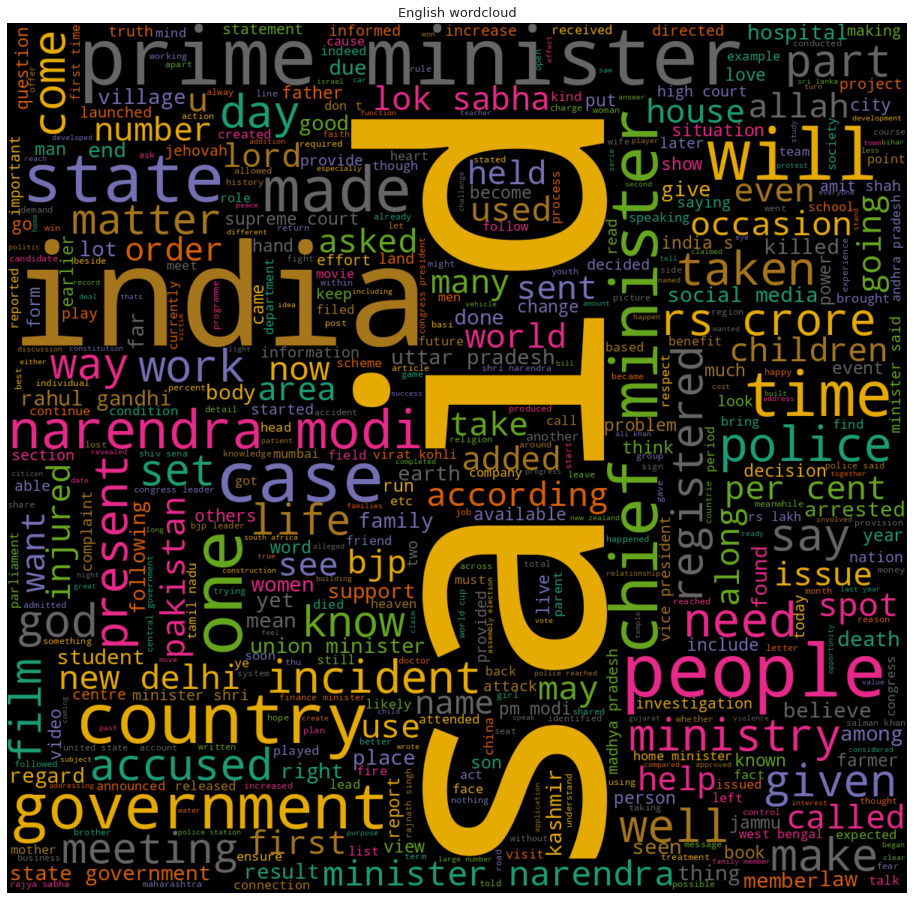

In [74]:
# this step might take a few minutes to complete

wc = WordCloud(width=1200, height=1160, max_words=500,colormap="Dark2").generate(english_sentences)

plt.figure(figsize=(20,16))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("English wordcloud",fontsize=13)
plt.show()

### Hindi

In [75]:
hindi_sentences = ""
for sentence in Y_tokenized:
    hindi_sentences += sentence

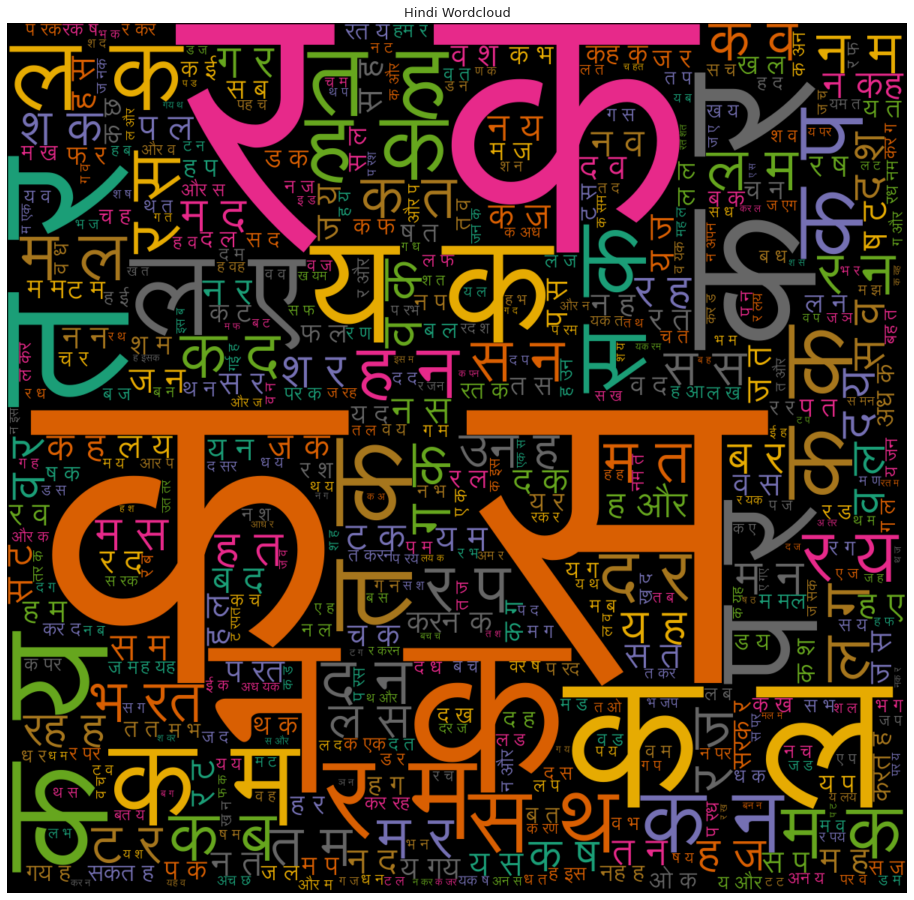

In [76]:
# this step might take more than 10 minutes to complete

wordcloud = WordCloud(font_path='Lohit-Devanagari.ttf',width=1200, height=1160, max_words=500,colormap="Dark2").generate(hindi_sentences)

plt.figure(figsize=(20,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Hindi Wordcloud",fontsize=13)
plt.show()

## Token count

In [77]:
from nltk.probability import FreqDist
import nltk
import string

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [78]:
final_tokens = []
for sent in X_tokenized:
    final_tokens.extend(sent.split())

print(len(final_tokens))

154610286


In [79]:
remove_these = set(stopwords.words('english') + list(string.punctuation) + list(string.digits))

In [80]:
filtered_text = [w for w in final_tokens if not w in remove_these]
fdist_filtered = FreqDist(filtered_text)

In [81]:
print("Total Number of tokens : ", fdist_filtered.N())
print("Total Number of tokens : ", len(fdist_filtered))

Total Number of tokens :  78983068
Total Number of tokens :  730658


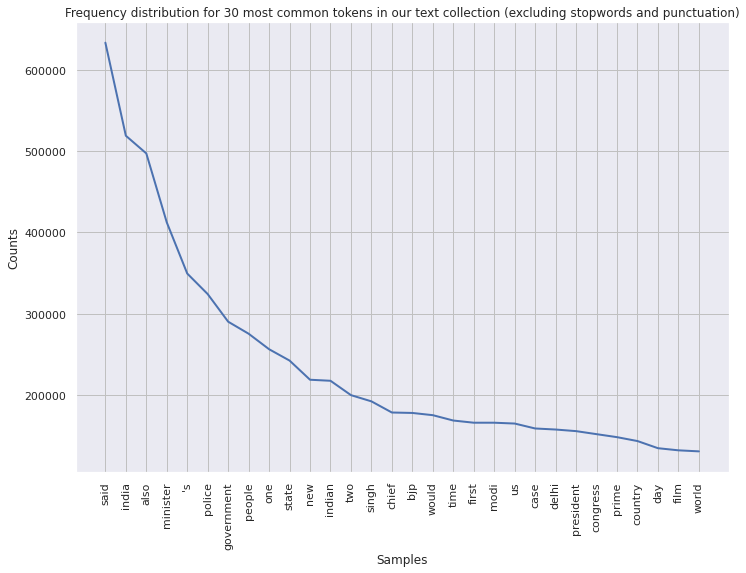

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)'}, xlabel='Samples', ylabel='Counts'>

In [82]:
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')

In [83]:
final_tokens_hindi = []
for sent in Y_tokenized:
    final_tokens_hindi.extend(sent.split())

print(len(final_tokens_hindi))

169413294


In [84]:
fdist_hin = FreqDist(final_tokens_hindi)
fdist_hin

FreqDist({'के': 6433594, '।': 5503719, 'में': 4537613, 'है': 4359826, ',': 4176940, 'की': 3651535, 'और': 3275234, 'को': 2553004, 'से': 2415190, 'ने': 2079396, ...})

In [85]:
print("Total number of tokens : ", fdist_hin.N())
print("Total number of unique tokens : ", len(fdist_hin))

Total number of tokens :  169413294
Total number of unique tokens :  1021217


In [86]:
hindi_tokens = {}

for token in final_tokens_hindi:
    if token in hindi_tokens:
        hindi_tokens[token] += 1
    else:
        hindi_tokens[token] = 1 

In [87]:
sorted_hindi_tokens = sorted(hindi_tokens.items(), key=lambda x: x[1], reverse=True)

In [88]:
dict_for_plot = {}
for x in sorted_hindi_tokens[0:30]:
    dict_for_plot[x[0]] = x[1]

In [89]:
dict_for_plot.keys()

dict_keys(['के', '।', 'में', 'है', ',', 'की', 'और', 'को', 'से', 'ने', 'का', '.', 'हैं', 'पर', 'कि', '"', '-', 'लिए', 'एक', '(', ')', 'भी', 'नहीं', 'किया', 'इस', 'कहा', 'कर', 'यह', 'करने', "'"])

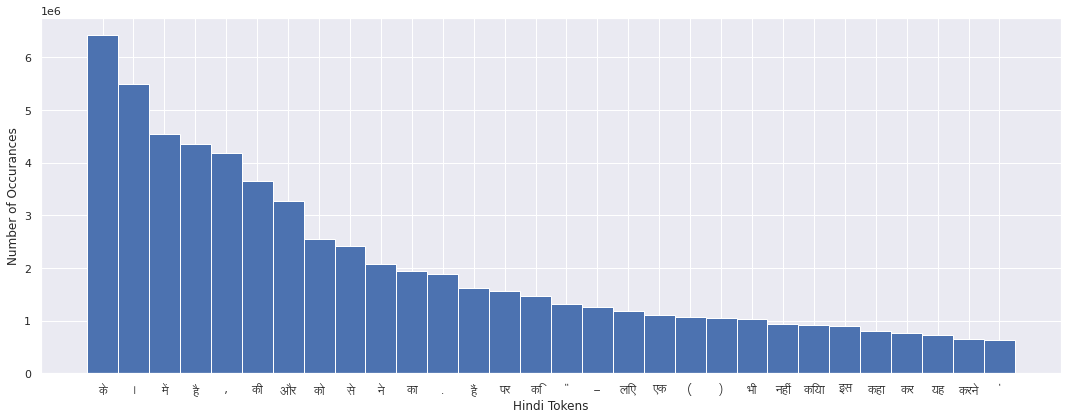

In [92]:
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='Lohit-Devanagari.ttf')

fig, ax = plt.subplots(figsize = (15, 6))
idx = np.asarray([i for i in range(30)])

ax.bar(idx, [val for key,val in sorted(dict_for_plot.items(), key=lambda x: x[1], reverse=True)], width=1)
ax.set_xticks(idx)
ax.set_xticklabels(list(dict_for_plot.keys()), font=fp)
ax.set_xlabel('Hindi Tokens')
ax.set_ylabel('Number of Occurances')
fig.tight_layout()
plt.show()

## 9. Train, Validation and Test Split

In [93]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_tokenized, Y_tokenized, test_size=0.10, random_state=1, shuffle = False)

In [94]:
print("Example : \n")
print(X_train_val[65])
print("\n")
print(Y_train_val[65])

Example : 

add onions , green chillies , coriander , ginger and garlic .



हींग , राई , कढ़ी पत्ता , अदरक प्यूरी व हरी मिर्च डालें । 



In [95]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.02, random_state=1, shuffle = False)

In [96]:
print(len(X_train), len(Y_train), len(X_val), len(Y_val), len(X_test), len(Y_test))

7465803 7465803 152364 152364 846464 846464


In [97]:
with open(dataset_root + "/final_train_norm_lf_{0}_tk_moses.en".format(filtering_length), "w") as output:
    output.writelines(X_train)

In [98]:
with open(dataset_root + "/final_train_norm_lf_{0}_tk_indicnlp.hi".format(filtering_length), "w") as output:
    output.writelines(Y_train)

In [99]:
with open(dataset_root + "/final_test_norm_lf_{0}_tk_moses.en".format(filtering_length), "w") as output:
    output.writelines(X_test)

In [100]:
with open(dataset_root + "/final_test_norm_lf_{0}_tk_indicnlp.hi".format(filtering_length), "w") as output:
    output.writelines(Y_test)

In [101]:
with open(dataset_root + "/final_val_norm_lf_{0}_tk_moses.en".format(filtering_length), "w") as output:
    output.writelines(X_val)

In [102]:
with open(dataset_root + "/final_val_norm_lf_{0}_tk_indicnlp.hi".format(filtering_length), "w") as output:
    output.writelines(Y_val)

In [103]:
print("Data analysis and preparation is done")

Data analysis and preparation is done
